In [1]:
# Import necessary libraries
#remove .legacy if not M1 mac
import numpy as np
from keras.initializers import GlorotUniform
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras.models as models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers.legacy import SGD #MAC M1 compatible with legacy
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Optimizer #MAC M1 compatible with legacy
import keras.backend as K
from keras.optimizers.legacy import Adagrad #MAC M1 compatible with legacy
from keras.optimizers.legacy import RMSprop #MAC M1 compatible with legacy
from keras.optimizers.legacy import Adam #MAC M1 compatible with legacy
from keras.utils import to_categorical
from keras.optimizers.legacy import Nadam
from sklearn.model_selection import train_test_split

In [2]:
# Load data from CSV file

tdata=pd.read_csv("team13/task3/training_data_set_13_labeled.csv",header=None) 
train_data_labeled=tdata.iloc[:, :-1].values
train_labels=tdata.iloc[:, -1].values

tudata=pd.read_csv("team13/task3/training_data_set_13_unlabeled.csv",header=None)
train_data_unlabeled=tudata.values

tedata=pd.read_csv("team13/task3/testing_data_set_13.csv",header=None)
test_data=tedata.iloc[:, :-1].values
test_labels=tedata.iloc[:, -1].values

vdata=pd.read_csv("team13/task3/validation_data_set_13.csv",header=None)
val_data=vdata.iloc[:, :-1].values
val_labels=vdata.iloc[:, -1].values

In [3]:
# Define parameters
input_size = train_data_unlabeled.shape[1]
num_classes = tedata.iloc[:, -1].nunique()
learning_rate = 0.01
num_epochs = 200
#Number of batches is 10 so batch size =200 # not working
batch_size = 100
stopping_threshold = 0.001
train_labels=to_categorical(train_labels, num_classes)
test_labels=to_categorical(test_labels, num_classes)
val_labels=to_categorical(val_labels, num_classes)
print("Input size: ", input_size)
print("Number of classes: ", num_classes)
print(tdata.head())

Input size:  36
Number of classes:  5
         0         1         2         3         4         5         6    
0  0.218191  0.208662  0.191366  0.165066  0.118537  0.022427  0.088664  \
1  0.064672  0.195759  0.067322  0.253010  0.253010  0.063271  0.148429   
2  0.075965  0.186090  0.134945  0.160456  0.200401  0.297849  0.297849   
3  0.268359  0.122221  0.106275  0.058994  0.268359  0.233871  0.062075   
4  0.071750  0.062094  0.019035  0.076779  0.265496  0.262281  0.074382   

         7         8         9   ...        27        28        29        30   
0  0.182101  0.218191  0.218191  ...  0.197390  0.218191  0.125419  0.076314  \
1  0.251602  0.097888  0.094661  ...  0.207258  0.130651  0.253010  0.101742   
2  0.049709  0.221631  0.178490  ...  0.297849  0.043976  0.050890  0.054529   
3  0.065606  0.268359  0.052461  ...  0.164526  0.078953  0.096584  0.200693   
4  0.069184  0.139595  0.184704  ...  0.265496  0.265496  0.265496  0.265496   

         31        32        3

In [4]:
# Define function to build model
def build_AANN_model(input_d):
    model = Sequential([
        Dense(input_d-4, input_shape=(input_d,), activation='tanh'),  # Hidden layer 1
        Dense(input_d-8, activation=None),  # Hidden layer 2
        Dense(input_d-4, activation='tanh'),  # Hidden layer 3
        Dense(input_d, activation=None)  # Output layer
    ])
    return model

def build_DFNN_model(input_d):
    model = Sequential([
        Dense(input_d-4, input_shape=(input_d,), activation='tanh'),  # Hidden layer 1
        Dense(input_d-8, activation=None),  # Hidden layer 2
        Dense(input_d-12, activation='tanh'),  # Hidden layer 3
        Dense(input_d-16, activation=None),  # Hidden layer 4
        Dense(input_d-20, activation='tanh'),  # Hidden layer 5
        Dense(input_d-24, activation=None),  # Hidden layer 6
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

In [5]:
# Train the model
def train_AANN_model(model, train_data_AANN, train_output_AANN):
    split_train_data, split_val_data = train_test_split(train_data_AANN, test_size=0.2, random_state=42)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=stopping_threshold, patience=5,mode='auto', restore_best_weights=True)
    history = model.fit(split_train_data, split_train_data, verbose=0, epochs=200, batch_size = batch_size, validation_data=(split_val_data, split_val_data),callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='Training Error')
    plt.plot(history.history['val_loss'], label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Average Error')
    plt.title('Average Error vs. Epoch')
    plt.legend()
    plt.show()

In [6]:
# Train the model
def train_DFNN_model(model):
    train_errors = []  # List to store average error on training data for each epoch
    test_errors = []   # List to store average error on test data for each epoch
    val_errors = []   # List to store average error on validation data for each epoch

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=stopping_threshold, patience=5,mode='auto', restore_best_weights=True)
    history = model.fit(train_data_labeled, train_labels, verbose=0, epochs=200, batch_size = batch_size, validation_data=(val_data, val_labels),callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='Training Error')
    plt.plot(history.history['val_loss'], label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Average Error')
    plt.title('Average Error vs. Epoch')
    plt.legend()
    plt.show()

    # Generate predictions on training and test data
    train_predictions = model.predict(train_data_labeled)
    test_predictions = model.predict(test_data)

    # Calculate confusion matrices for training and test data
    train_confusion_matrix = confusion_matrix(np.argmax(train_labels, axis=1), np.argmax(train_predictions, axis=1))
    test_confusion_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(test_predictions, axis=1))

    # return train_confusion_matrix, test_confusion_matrix, convergence_epoch
    return train_confusion_matrix, test_confusion_matrix, np.argmin(history.history['val_loss'])

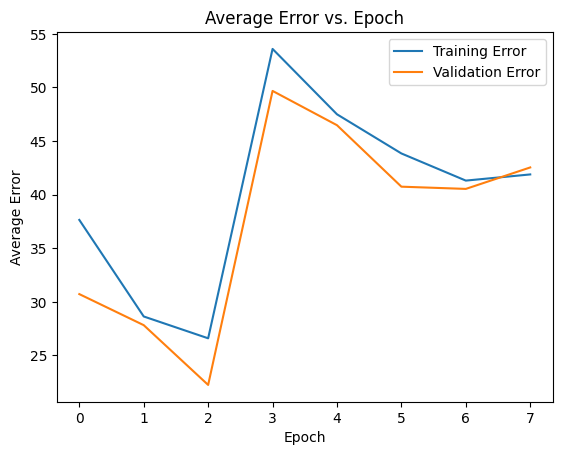

55/55 [==============================] - 0s 383us/step


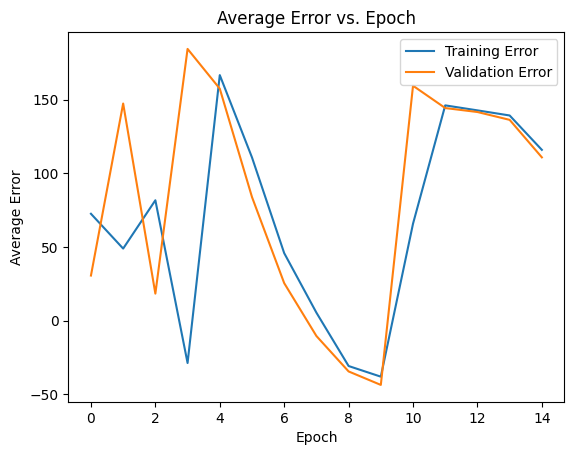

55/55 [==============================] - 0s 391us/step


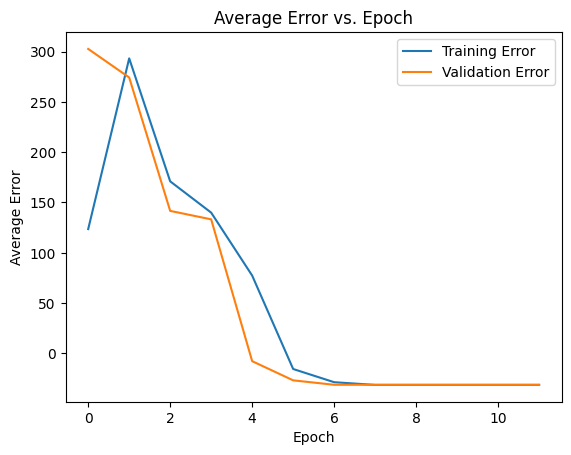

In [7]:
# Build and compile the model with no normalization
AANN1 = build_AANN_model(input_size)
AANN1.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])
AANN2 = build_AANN_model(input_size-8)
AANN2.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])
AANN3 = build_AANN_model(input_size-16)
AANN3.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with no normalization
train_AANN_model(AANN1, train_data_unlabeled, train_data_unlabeled)

hidden_layer_model=models.Model(inputs=AANN1.input, outputs=AANN1.layers[1].output)
bottle_neck1_output=hidden_layer_model.predict(train_data_unlabeled)

train_AANN_model(AANN2, bottle_neck1_output, bottle_neck1_output)

hidden_layer_model=models.Model(inputs=AANN2.input, outputs=AANN2.layers[1].output)
bottle_neck2_output=hidden_layer_model.predict(bottle_neck1_output)

train_AANN_model(AANN3, bottle_neck2_output, bottle_neck2_output)

In [8]:
def accuracy_from_confusion_matrix(confusion_matrix):
  diagonal_sum = np.trace(confusion_matrix)
  total_sum = np.sum(confusion_matrix)
  accuracy = diagonal_sum / total_sum
  return accuracy

In [9]:
def xavier_init(shape):
    # np.random.seed(42)  # Set random seed for reproducibility
    return np.random.randn(*shape) * np.sqrt(2.0 / (shape[0] + shape[1]))

In [10]:
pretrained_weights_AE1 = AANN1.get_weights()[:4]
pretrained_weights_AE2 = AANN2.get_weights()[:4]
pretrained_weights_AE3 = AANN3.get_weights()[:4]
pretrained_weights_W1 = pretrained_weights_AE1[0]
pretrained_weights_Wb1 = pretrained_weights_AE1[1]
pretrained_weights_W2 = pretrained_weights_AE1[2]
pretrained_weights_Wb2 = pretrained_weights_AE1[3]
pretrained_weights_W3 = pretrained_weights_AE2[0]
pretrained_weights_Wb3 = pretrained_weights_AE2[1]
pretrained_weights_W4 = pretrained_weights_AE2[2]
pretrained_weights_Wb4 = pretrained_weights_AE2[3]
pretrained_weights_W5 = pretrained_weights_AE3[0]
pretrained_weights_Wb5 = pretrained_weights_AE3[1]
pretrained_weights_W6 = pretrained_weights_AE3[2]
pretrained_weights_Wb6 = pretrained_weights_AE3[3]
Wk = xavier_init((12, num_classes))
Wbk = np.zeros(num_classes)
weights_DFNN = pretrained_weights_AE1 + pretrained_weights_AE2 + pretrained_weights_AE3 + [Wk, Wbk]

for i in weights_DFNN:
  print(i.shape)

# x=pretrained_weights_AE1[1]
# y=x.transpose()
# print(y.shape)
# print(pretrained_weights_AE1[1].transpose())
# print(len(pretrained_weights_AE1[1]),len(pretrained_weights_AE1[0][0]),sep=" ")


(36, 32)
(32,)
(32, 28)
(28,)
(28, 24)
(24,)
(24, 20)
(20,)
(20, 16)
(16,)
(16, 12)
(12,)
(12, 5)
(5,)


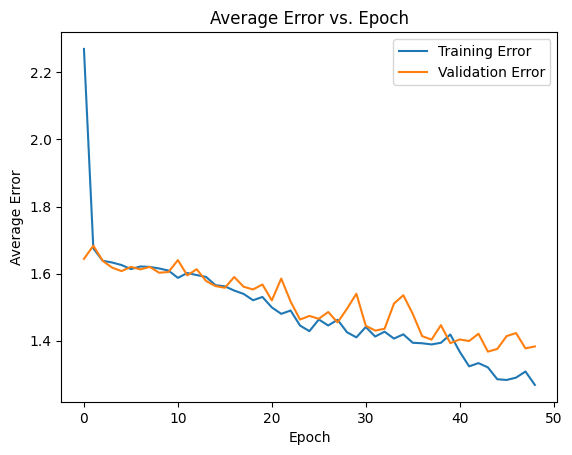

8/8 [==============================] - 0s 510us/step
[[87  8  9 38  8]
 [ 5 89 28 21  7]
 [10 45 41 40 14]
 [27  1 18 96  8]
 [20 13 28 65 24]]
[[19  3  5 13  4]
 [ 1 29  6 12  3]
 [ 4  8 20 19  5]
 [ 7  1  7 34  1]
 [ 9  8 12 14  6]]
Train Accuracy: 0.4493333333333333
Test Accuracy: 0.432
Convergence Epoch: 43


In [11]:
# Build and compile the model with no normalization
DFNN = build_DFNN_model(input_size)
DFNN.compile(optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss='categorical_crossentropy', metrics=['accuracy'])

DFNN.set_weights(weights_DFNN)

# Train the model with no normalization
train_confusion_matrix, test_confusion_matrix, convergence_epoch = train_DFNN_model(DFNN)

print(train_confusion_matrix)
print(test_confusion_matrix)
# Calculate accuracy for training data
train_accuracy = accuracy_from_confusion_matrix(train_confusion_matrix)
print("Train Accuracy:", train_accuracy)
# Calculate accuracy for test data
test_accuracy = accuracy_from_confusion_matrix(test_confusion_matrix)
print("Test Accuracy:", test_accuracy)
print("Convergence Epoch:", convergence_epoch)